# LangGraph w/ SGLang
### This notebook powers an orchestrated agent using locally hosted Qwen model running on SGLang

---


# imports

In [1]:
# =====================================================
# === 1. imports (11 LOC) =============================
# =====================================================
import cudf.pandas
cudf.pandas.install()
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

from typing import TypedDict, Annotated, List
import operator

/home/will/git/quant-agent/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# =====================================================
# === 2. LLM setup (6 LOC) ============================
# =====================================================

llm = ChatOpenAI(
    # Local SGLang:
    # uv run python3 -m sglang.launch_server \                                                             ─╯
    #   --model-path Qwen/Qwen2.5-14B-Instruct \
    #   --host 0.0.0.0 --port 8000 \
    #   --tool-call-parser qwen


    model="Qwen/Qwen2.5-14B-Instruct",
    base_url="http://localhost:8000/v1",
    api_key="not-used",  # required by ChatOpenAI, ignored by SGLang
            
    temperature=0.1,
    max_tokens=None,
    stream_usage=True,  # Include token usage in streaming responses
)

In [3]:
# =====================================================
# === 3. Data ( 1 LOC ) ===============================
# =====================================================
# Toy, Sample DataFrame
df = pd.DataFrame({
    'date': pd.date_range('2024-01-01', periods=10),
    'sales': [1_000_000, 120, 115, 140, 160, 155, 180, 190, 185, 200],
    'profits': [20, 25, 23, 30, 35, 33, 40, 42, 41, 45]
})

# Python Tool

In [4]:
# =====================================================
# === 4. Tools ( 5 LOC ) ==============================
# =====================================================
# Define tool to execute Python code

SAFE_BUILTINS = {
    "len": len,
    "range": range,
    "min": min,
    "max": max,
    "sum": sum,
    "abs": abs,
    "sorted": sorted,
}

@tool
def execute_python(code: str) -> str:
    """Execute Python code to analyze the DataFrame 'df'.
    Variables available: df (pandas DataFrame), pd (pandas module).
    Return only valid Python code. Do not print. 
    Always assign the final answer to a variable named result.
    """
    try:
        local_vars = {"df": df, "pd": pd}
        exec(code, {"__builtins__": SAFE_BUILTINS, "pd": pd}, local_vars)
        return str(local_vars.get("result", "Code executed. Use 'result' variable."))
    except Exception as e:
        return f"Error: {str(e)}"

# Agent State

In [5]:
# =================================================================
# === 5. Custom State ( 4 LOC ) ===================================
# =================================================================

class AgentState(TypedDict):
    # Conversation history (reducer appends messages)
    messages: Annotated[List[BaseMessage], operator.add]
    # High-level plan from planner node
    plan: str
    # Code string or instructions from coder node
    code: str
    # Final numeric/text result (optional, for demo)
    result: str

# Planner Agent

In [6]:
# =================================================================
# === 6. Planner Agent ( 4 LOC ) ==================================
# =================================================================

def planner_agent(state: AgentState):
    """Decides what analysis to perform and writes a 'plan' into state."""
    
    system = SystemMessage(content="""You are a planning agent. 
    Analyze the user's question and describe what calculation needs to be done.
    Be specific about the operation (mean, sum, max, etc.) and column.""")
    
    messages = [system] + state["messages"]
    planner_reply = llm.invoke(messages)
    
    return {
        # Keep ALL prior messages:
        # "messages": state["messages"] + [planner_reply],
        
        # Only keep last message:
        "messages": [planner_reply],
        "plan": planner_reply.content,
    }


# Coding Agent

In [7]:
# =================================================================
# === 7. Coding Agent ( 6 LOC ) ===================================
# =================================================================
# declare once
llm_with_tools = llm.bind_tools([execute_python])

def coder_agent(state: AgentState):
    """Generates and executes code/instructions (via tool calls)"""
    system = SystemMessage(content=f"""You are a coding agent.
    DataFrame 'df' has columns: {list(df.columns)}.
    Sample data: {df.head(3).to_string()}
    
    Write Python and pandas code to solve the task.""")
    
    messages = [system] + state["messages"]
    coder_reply = llm_with_tools.invoke(messages)
    # Extract code for state tracking (optional)
    code_str = coder_reply.content or ""
    if hasattr(coder_reply, "tool_calls") and bool(coder_reply.tool_calls):
        code_str = coder_reply.tool_calls[0].get("args", {}).get("code", "")
    
    return {
        "messages": [coder_reply],
        "code": code_str
        }  

# Conditional Routing

In [8]:
# =================================================================
# === 8. Routing Logic ( 3 LOC ) ==================================
# =================================================================
def should_continue(state: AgentState):
    last_msg = state["messages"][-1]
    if hasattr(last_msg, "tool_calls") and bool(last_msg.tool_calls):
        return "tools"    
    return END

# Build Graph

In [9]:
# =====================================================
# === 9. Build Graph ( 9 LOC ) ========================
# =====================================================
graph = StateGraph(AgentState)

# Add Nodes
graph.add_node("planner", planner_agent)
graph.add_node("coder", coder_agent)
graph.add_node("tools", ToolNode([execute_python]))

# Define flow: START -> Planner -> Coder -> Tools (if needed) -> END
graph.add_edge(START, "planner")
graph.add_edge("planner", "coder")

# Orchestrated decision:
# - if coder produced tool calls -> "tools", otherwise -> END
graph.add_conditional_edges("coder", should_continue, ["tools", END])

# Loop back from tools to coder so multiple tool calls are possible
graph.add_edge("tools", "coder")
app = graph.compile()

# "Studio" 🤣

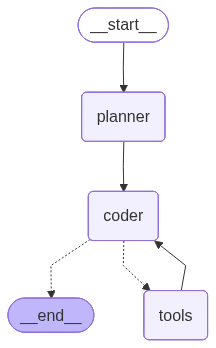

In [10]:
display(app)

# Test - No Streaming

In [11]:
# =====================================================
# === Test Run ========================================
# =====================================================
desc_df = df[['sales', 'profits']].agg(['min', 'mean', 'std', 'var', 'sum', 'max'])
display(desc_df)

print('\n' + '*'*20 + '\n\n')

prompt = "What are the average sales?"
print(f'PROMPT: "{prompt}"\n')
result = app.invoke({"messages": [HumanMessage(content=prompt)]})
print("RESULT:", result['messages'][-1].content, '\n\n')

print('*'*20 + '\n\n')

prompt = "What are the total sales?"
print(f'PROMPT: "{prompt}"\n')
result = app.invoke({"messages": [HumanMessage(content=prompt)]})
print("RESULT:", result['messages'][-1].content, '\n\n')


print('*'*20 + '\n\n')

prompt = "What is the variance of the profits?"
print(f'PROMPT: "{prompt}"\n')
result = app.invoke({"messages": [HumanMessage(content=prompt)]})
print("RESULT:", result['messages'][-1].content, '\n\n')

print('*'*20 + '\n\n')

prompt = "What is 2 + 2 ?"
print(f'PROMPT: "{prompt}"\n')
result = app.invoke({"messages": [HumanMessage(content=prompt)]})
print("RESULT:", result['messages'][-1].content, '\n')

print('*'*20 + '\n\n')

desc_df

,sales,profits
min,115.00,20.00
mean,100144.50,33.40
std,316177.00,8.71
var,99967892308.06,75.82
sum,1001445.00,334.00
max,1000000.00,45.00



********************


PROMPT: "What are the average sales?"

RESULT: The average sales value is 100144.5. 


********************


PROMPT: "What are the total sales?"

RESULT: The total sales amount to 1,001,445. 


********************


PROMPT: "What is the variance of the profits?"

RESULT: The variance of the profits in the DataFrame is approximately 75.82. 


********************


PROMPT: "What is 2 + 2 ?"

RESULT: The result of 2 + 2 is 4. 

********************




,sales,profits
min,115.00,20.00
mean,100144.50,33.40
std,316177.00,8.71
var,99967892308.06,75.82
sum,1001445.00,334.00
max,1000000.00,45.00


---

# Test - Streaming ON
This is the streaming output including the reasoning in green

In [17]:
# =====================================================
# === Streaming Test ==================================
# =====================================================
import json
import re

# ANSI color codes
DIM_GREEN = "\033[2;32m"
YELLOW = "\033[93m"
CYAN = "\033[96m"
# GRAY = "\033[90m"
GRAY = "\033[38;5;241m"
BLUE = "\033[94m"
RESET = "\033[0m"

def parse_tool_call(text: str) -> dict | None:
    """Extract tool call from text - handles both <tool_call> tags and raw JSON."""
    # Try <tool_call> tags first
    match = re.search(r'<tool_call>\s*(\{.*?\})\s*</tool_call>', text, re.DOTALL)
    if match:
        try:
            return json.loads(match.group(1))
        except json.JSONDecodeError:
            pass
    
    # Try raw JSON with "name": "execute_python"
    match = re.search(r'(\{"name":\s*"execute_python".*?\})\s*\}', text, re.DOTALL)
    if match:
        try:
            # Add closing brace if needed
            json_str = match.group(0)
            return json.loads(json_str)
        except json.JSONDecodeError:
            pass
    
    return None

async def stream_invoke(prompt: str):
    """Stream agent execution with live token output."""
    print(f'PROMPT: "{prompt}"\n')
    inputs = {"messages": [HumanMessage(content=prompt)]}

    current_node = None
    tool_was_called = False
    total_input_tokens = 0
    total_output_tokens = 0
    accumulated_content = ""  # Buffer for parsing tool calls

    async for event in app.astream_events(inputs, version="v2"):
        kind = event["event"]

        # Track which node we're in
        if kind == "on_chain_start" and event.get("name") in ["planner", "coder"]:
            current_node = event["name"]

        # Stream LLM tokens as they arrive
        if kind == "on_chat_model_stream":
            chunk = event["data"]["chunk"]
            if chunk.content:
                accumulated_content += chunk.content
                
                # Final answer (coder after tool call) - default color
                if current_node == "coder" and tool_was_called:
                    print(f"{chunk.content}", end="", flush=True)
                # Reasoning (planner or coder before tool) - subdued green
                else:
                    print(f"{DIM_GREEN}{chunk.content}{RESET}", end="", flush=True)

            # Capture token usage from the final chunk
            if chunk.usage_metadata:
                total_input_tokens += chunk.usage_metadata.get("input_tokens", 0)
                total_output_tokens += chunk.usage_metadata.get("output_tokens", 0)

        # Show when tools are called (in yellow)
        elif kind == "on_tool_start":
            tool_name = event.get("name", "unknown")
            tool_input = event.get("data", {}).get("input", {})
            code = tool_input.get("code", "")[:100]  # First 100 chars
            print(f"\n{YELLOW}[Tool: {tool_name}]{RESET}")
            if code:
                print(f"{BLUE}Code: {code}...{RESET}" if len(code) == 100 else f"{BLUE}Code: {code}{RESET}")

        # Show tool results (in cyan)
        elif kind == "on_tool_end":
            tool_was_called = True
            result = str(event.get("data", {}).get("output", ""))
            print(f"{CYAN}[Result: {result}]{RESET}\n")

    # Fallback: Parse tool call from text if no tool was executed
    if not tool_was_called and "execute_python" in accumulated_content:
        tool_call = parse_tool_call(accumulated_content)
        if tool_call and tool_call.get("name") == "execute_python":
            code = tool_call.get("arguments", {}).get("code", "")
            if code:
                print(f"\n{YELLOW}[Tool: execute_python (fallback)]{RESET}")
                print(f"{BLUE}Code: {code[:100]}{'...' if len(code) > 100 else ''}{RESET}")
                result = execute_python.invoke({"code": code})
                print(f"{CYAN}[Result: {result}]{RESET}")
                print(f"\nThe answer is: {result}")

    # Print token stats
    total_tokens = total_input_tokens + total_output_tokens
    print(f"\n{GRAY}[Tokens: {total_input_tokens} in / {total_output_tokens} out / {total_tokens} total]{RESET}\n")


# Run streaming tests
desc_df = df[['sales', 'profits']].agg(['min', 'mean', 'std', 'var', 'sum', 'max'])
display(desc_df)

print('\n' + '*'*20 + '\n')
await stream_invoke("What are the average sales?")

print('*'*20 + '\n')
await stream_invoke("What are the total sales?")

print('*'*20 + '\n')
await stream_invoke("What is the variance of the profits?")

print('*'*20 + '\n')
await stream_invoke("What is 2 + 2 ?")

print('*'*20 + '\n')
desc_df

,sales,profits
min,115.00,20.00
mean,100144.50,33.40
std,316177.00,8.71
var,99967892308.06,75.82
sum,1001445.00,334.00
max,1000000.00,45.00



********************

PROMPT: "What are the average sales?"

To answer the question about the average sales, the calculation needed is to compute the mean of the sales column. This involves summing up all the values in the sales column and then dividing by the number of entries in that column.
[Tool: execute_python]
Code: result = df['sales'].mean()
[Result: content='100144.5' name='execute_python' tool_call_id='call_c7b726ceca754ac6bc926823']

The average sales value is 100144.5.
[Tokens: 835 in / 90 out / 925 total]

********************

PROMPT: "What are the total sales?"

To calculate the total sales, you need to sum up the values in the sales column.
[Tool: execute_python]
Code: result = df['sales'].sum()
[Result: content='1001445' name='execute_python' tool_call_id='call_8e9a02dd827943b4ae0ede89']

The total sales amount to 1,001,445.
[Tokens: 778 in / 63 out / 841 total]

********************

PROMPT: "What is the variance of the profits?"

To calculate the variance of the pro

,sales,profits
min,115.00,20.00
mean,100144.50,33.40
std,316177.00,8.71
var,99967892308.06,75.82
sum,1001445.00,334.00
max,1000000.00,45.00
